In [1]:
!pip install nba_api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.9/284.9 kB 4.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import teams
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.losses import BinaryCrossentropy

In [3]:
# Get stats for each team
from nba_api.stats.endpoints import leaguedashteamstats

raw_team_stats_21_22 = leaguedashteamstats.LeagueDashTeamStats(season_type_all_star="Regular Season", season="2021-22")
team_dataframe_21_22 = raw_team_stats_21_22.get_data_frames()[0]

gsw_21_22 = team_dataframe_21_22[team_dataframe_21_22.TEAM_ID == 1610612744]
gsw_21_22

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
9,1610612744,Golden State Warriors,82,53,29,0.646,3946.0,3323,7087,0.469,...,7,5,29,4,18,2,27,29,15,5


In [4]:
# Helpers
def get_season_from_start(start_year: str) -> str:
  return "{}-{}".format(start_year, int(start_year[2:]) + 1)

def get_id_by_abbreviation(abbreviation: str) -> int:
  return teams.find_team_by_abbreviation(abbreviation=abbreviation)["id"]

# Given BKN @ MIL and you are BKN, should return MIL
def get_opponent(game_matchup: str, your_team: str):
  matchup_components = game_matchup.split(" ")
  left_team, right_team = matchup_components[0], matchup_components[2]
  if your_team == left_team:
    return right_team
  else:
    return left_team

def convertWLto01(wl: str) -> int:
  return 1 if wl == 'W' else 0

def get_team_stat_name(stat: str) -> str:
  return "TEAM_{}".format(stat)

def get_opponent_stat_name(stat: str) -> str:
  return "OPPONENT_{}".format(stat)

def generate_nn_labels(stats: list[str]):
  team_and_opponent_labels = []
  for stat in stats:
    team_and_opponent_labels.append("TEAM_{}".format(stat))
    team_and_opponent_labels.append("OPPONENT_{}".format(stat))
  return team_and_opponent_labels

In [5]:
# Helper class to simplify season handling
class Season:
  def __init__(self, start_year: str):
    self.start_year = start_year
  def formatted_season(self):
    # "2021" -> "2021-"
    return get_season_from_start(self.start_year)


In [6]:
# Convenience objects
season_2021 = Season("2021")
season_2022 = Season("2022")
season_2023 = Season("2023")

In [7]:
from nba_api.stats.endpoints import cumestatsteamgames

def fetch_all_team_stats(start_year: Season):
  # Requires format 2025-26 season for 2025-2026 season
  all_teams_raw = leaguedashteamstats.LeagueDashTeamStats(season_type_all_star="Regular Season", season=start_year.formatted_season())

  return all_teams_raw.get_data_frames()[0]


In [8]:
team_stats_2021 = fetch_all_team_stats(season_2021)
team_stats_2022 = fetch_all_team_stats(season_2022)
team_stats_2023 = fetch_all_team_stats(season_2023)

In [9]:
team_stats_2023

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
0,1610612737,Atlanta Hawks,82,36,46,0.439,3971.0,3529,7584,0.465,...,6,16,16,16,26,22,15,7,5,21
1,1610612738,Boston Celtics,82,64,18,0.780,3966.0,3601,7396,0.487,...,2,14,1,27,1,1,2,30,2,1
2,1610612751,Brooklyn Nets,82,32,50,0.390,3961.0,3334,7307,0.456,...,11,20,12,28,12,16,13,21,25,22
3,1610612766,Charlotte Hornets,82,21,61,0.256,3946.0,3281,7133,0.460,...,30,26,18,25,25,13,7,29,28,30
4,1610612741,Chicago Bulls,82,39,43,0.476,3996.0,3448,7339,0.470,...,14,23,3,9,18,14,17,14,22,20
5,1610612739,Cleveland Cavaliers,82,48,34,0.585,3961.0,3425,7147,0.479,...,17,8,17,19,21,17,5,16,20,13
6,1610612742,Dallas Mavericks,82,50,32,0.610,3941.0,3535,7352,0.481,...,21,19,4,24,17,2,10,2,7,14
7,1610612743,Denver Nuggets,82,57,25,0.695,3941.0,3610,7279,0.496,...,7,3,5,21,10,12,9,26,14,4
8,1610612765,Detroit Pistons,82,14,68,0.171,3951.0,3353,7236,0.463,...,16,22,28,30,20,25,28,28,27,28
9,1610612744,Golden State Warriors,82,46,36,0.561,3966.0,3582,7515,0.477,...,1,4,23,23,23,15,22,24,8,12


In [10]:
# Returns a table of game, with a team and opponent + corresponding win percentages
# This WILL duplicate games
def prepare_dataset(season_start_year: Season, team_stats, additional_columns: list[str]=[]):
  season_data = leaguegamefinder.LeagueGameFinder(season_nullable=season_start_year.formatted_season(), league_id_nullable="00", season_type_nullable="Regular Season")
  season_data_df = season_data.get_data_frames()[0]

  # Starting fresh with a new copy
  individual_games = pd.DataFrame()

  # Copy over basic columns
  individual_games["TEAM_NAME"] = season_data_df["TEAM_NAME"]
  individual_games["TEAM_ABBREVIATION"] = season_data_df["TEAM_ABBREVIATION"]
  individual_games["TEAM_ID"] = season_data_df["TEAM_ABBREVIATION"].map(get_id_by_abbreviation)
  individual_games["GAME_ID"] = season_data_df["GAME_ID"]

  # Extract opponent abbr. using pandas apply
  individual_games["OPPONENT_ABBREVIATION"] = season_data_df.apply(lambda x: get_opponent(game_matchup=x["MATCHUP"], your_team=x["TEAM_ABBREVIATION"]), axis=1)
  individual_games["OPPONENT_ID"] = individual_games["OPPONENT_ABBREVIATION"].map(get_id_by_abbreviation)
  individual_games["WL"] = season_data_df["WL"]

  for stat_name in additional_columns:
    # Remove team_name column to prevent name clash when merging
    id_to_win = team_stats[["TEAM_ID", stat_name]]

    # Map the team id to what their win percentage is
    individual_games = pd.merge(individual_games, id_to_win, how="left", on="TEAM_ID")
    individual_games.rename(columns={stat_name : get_team_stat_name(stat_name)}, inplace=True)

    # Requires left_on because the same columns have different names
    individual_games = pd.merge(individual_games, id_to_win, how="left", left_on="OPPONENT_ID", right_on="TEAM_ID")
    individual_games.rename(columns={stat_name : get_opponent_stat_name(stat_name)}, inplace=True)

    # Remove the leftover columns from merging on columns with different names\
    # We end up with TEAM_ID_x and TEAM_ID_y
    # We drop y and rename x to just TEAM_ID
    individual_games = individual_games.drop(["TEAM_ID_y"], axis=1)
    individual_games.rename(columns={"TEAM_ID_x" : "TEAM_ID"}, inplace=True)
  individual_games["WIN"] = individual_games["WL"].map(convertWLto01)

  return individual_games

def prepare_win_pct_data(season: Season, team_stats):
  return prepare_dataset(season, team_stats, additional_columns=["W_PCT"])

# Using Naive Win Percentage Only

In [11]:
# Beware, this function will duplicate games (Which is intended in this case but may not always be true)
games_2021 = prepare_win_pct_data(season_2021, team_stats_2021)
tmp = games_2021[games_2021.GAME_ID == "0022101222"]
tmp

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN
1,Oklahoma City Thunder,OKC,1610612760,0022101222,LAC,1610612746,L,0.293,0.512,0
19,LA Clippers,LAC,1610612746,0022101222,OKC,1610612760,W,0.512,0.293,1


In [12]:
games_2022 = prepare_win_pct_data(season_2022, team_stats_2022)
games_2022

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN
0,Sacramento Kings,SAC,1610612758,0022201227,DEN,1610612743,L,0.585,0.646,0
1,Utah Jazz,UTA,1610612762,0022201228,LAL,1610612747,L,0.451,0.524,0
2,Toronto Raptors,TOR,1610612761,0022201221,MIL,1610612749,W,0.500,0.707,1
3,Oklahoma City Thunder,OKC,1610612760,0022201226,MEM,1610612763,W,0.488,0.622,1
4,Boston Celtics,BOS,1610612738,0022201216,ATL,1610612737,W,0.695,0.500,1
...,...,...,...,...,...,...,...,...,...,...
2455,Orlando Magic,ORL,1610612753,0022200003,DET,1610612765,L,0.415,0.207,0
2456,Boston Celtics,BOS,1610612738,0022200001,PHI,1610612755,W,0.695,0.659,1
2457,Los Angeles Lakers,LAL,1610612747,0022200002,GSW,1610612744,L,0.524,0.537,0
2458,Golden State Warriors,GSW,1610612744,0022200002,LAL,1610612747,W,0.537,0.524,1


In [13]:
games_2023 = prepare_win_pct_data(season_2023, team_stats_2023)
games_2023

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN
0,Milwaukee Bucks,MIL,1610612749,0022301191,ORL,1610612753,L,0.598,0.573,0
1,Golden State Warriors,GSW,1610612744,0022301198,UTA,1610612762,W,0.561,0.378,1
2,Orlando Magic,ORL,1610612753,0022301191,MIL,1610612749,W,0.573,0.598,1
3,Cleveland Cavaliers,CLE,1610612739,0022301187,CHA,1610612766,L,0.585,0.256,0
4,Chicago Bulls,CHI,1610612741,0022301190,NYK,1610612752,L,0.476,0.610,0
...,...,...,...,...,...,...,...,...,...,...
2455,Washington Wizards,WAS,1610612764,0022300064,IND,1610612754,L,0.183,0.573,0
2456,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,0.598,0.561,1
2457,Denver Nuggets,DEN,1610612743,0022300061,LAL,1610612747,W,0.695,0.573,1
2458,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0.561,0.598,0


In [14]:
# Combine all three recent seasons together
recent_three_seasons = pd.concat([games_2021, games_2022, games_2023])
#recent_three_seasons.sample(frac=1) # Shuffle data
recent_three_seasons

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN
0,Washington Wizards,WAS,1610612764,0022101217,CHA,1610612766,L,0.427,0.524,0
1,Oklahoma City Thunder,OKC,1610612760,0022101222,LAC,1610612746,L,0.293,0.512,0
2,Charlotte Hornets,CHA,1610612766,0022101217,WAS,1610612764,W,0.524,0.427,1
3,Atlanta Hawks,ATL,1610612737,0022101221,HOU,1610612745,W,0.524,0.244,1
4,Los Angeles Lakers,LAL,1610612747,0022101220,DEN,1610612743,W,0.402,0.585,1
...,...,...,...,...,...,...,...,...,...,...
2455,Washington Wizards,WAS,1610612764,0022300064,IND,1610612754,L,0.183,0.573,0
2456,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,0.598,0.561,1
2457,Denver Nuggets,DEN,1610612743,0022300061,LAL,1610612747,W,0.695,0.573,1
2458,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0.561,0.598,0


In [15]:
display(games_2023[games_2023['TEAM_ABBREVIATION'] == 'CLE'])

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN
3,Cleveland Cavaliers,CLE,1610612739,0022301187,CHA,1610612766,L,0.585,0.256,0
48,Cleveland Cavaliers,CLE,1610612739,0022301174,IND,1610612754,W,0.585,0.573,1
85,Cleveland Cavaliers,CLE,1610612739,0022301158,MEM,1610612763,W,0.585,0.329,1
131,Cleveland Cavaliers,CLE,1610612739,0022301132,LAC,1610612746,L,0.585,0.622,0
146,Cleveland Cavaliers,CLE,1610612739,0022301127,LAL,1610612747,L,0.585,0.573,0
...,...,...,...,...,...,...,...,...,...,...
2326,Cleveland Cavaliers,CLE,1610612739,0022300120,NYK,1610612752,W,0.585,0.610,1
2354,Cleveland Cavaliers,CLE,1610612739,0022300112,NYK,1610612752,L,0.585,0.610,0
2401,Cleveland Cavaliers,CLE,1610612739,0022300091,IND,1610612754,L,0.585,0.573,0
2423,Cleveland Cavaliers,CLE,1610612739,0022300081,OKC,1610612760,L,0.585,0.695,0


In [16]:
# We must convert to numpy as input to the neural network
# In the future the same approach can be used with any desired columns
raw_win_pct = recent_three_seasons[["TEAM_W_PCT", "OPPONENT_W_PCT"]].to_numpy()
raw_win_pct

array([[0.427, 0.524],
       [0.293, 0.512],
       [0.524, 0.427],
       ...,
       [0.695, 0.573],
       [0.561, 0.598],
       [0.573, 0.695]])

In [17]:
raw_labels = recent_three_seasons[["WIN"]].to_numpy()
raw_labels

array([[0],
       [0],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [18]:
training_size = 5000

train_input = raw_win_pct[:training_size]
train_label = raw_labels[:training_size]

test_input = raw_win_pct[training_size:]
test_label = raw_labels[training_size:]

In [19]:
from tensorflow.keras.optimizers import RMSprop

RNNmodel = Sequential()
RNNmodel.add(LSTM(1, input_shape=(2,1), return_sequences = False))
RNNmodel.add(Dense(20, activation='relu'))
RNNmodel.add(Dense(1, activation='sigmoid'))

RNNmodel.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=0.01),
    metrics=['accuracy']
)

#reshaping data to be 3d
train_input = train_input.reshape((train_input.shape[0], 2, 1))
test_input = test_input.reshape((test_input.shape[0], 2, 1))

history = RNNmodel.fit(train_input, train_label, epochs=20, validation_data = (test_input, test_label))

result = RNNmodel.evaluate(x=test_input, y=test_label)
dict(zip(RNNmodel.metrics_names, result))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4978 - loss: 0.6939 - val_accuracy: 0.5004 - val_loss: 0.6934
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5106 - loss: 0.6929 - val_accuracy: 0.4996 - val_loss: 0.6935
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5064 - loss: 0.6931 - val_accuracy: 0.4996 - val_loss: 0.6932
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4968 - loss: 0.6934 - val_accuracy: 0.5004 - val_loss: 0.6932
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4811 - loss: 0.6934 - val_accuracy: 0.4996 - val_loss: 0.6935
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4865 - loss: 0.6938 - val_accuracy: 0.5004 - val_loss: 0.6931
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4919 - loss: 0.6935 - val_accuracy: 0.4996 - val_loss: 0.6932
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4709 - loss: 0.6935 - val_accuracy:

{'loss': 0.6934276223182678, 'compile_metrics': 0.5004201531410217}

In [20]:
binary_results = RNNmodel.predict(x=test_input) > 0.5

correct_predictions = 0
total_predictions = 0
for result_pair in zip(binary_results, test_label):
  total_predictions += 1
  if (result_pair[0][0] == result_pair[1][0]):
    correct_predictions += 1

print("correct: {}, total: {}, accuracy pct: {}".format(correct_predictions, total_predictions, correct_predictions / total_predictions))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
correct: 1191, total: 2380, accuracy pct: 0.5004201680672269


# Adding Additional General Team Statistics

In [21]:
desired_stats = ["W_PCT", "FGA", "REB_RANK", "FG_PCT", "FG3_PCT", "FT_PCT", "OREB", "DREB", "AST", "TOV", "STL", "PFD", "PLUS_MINUS"]
more_2023 = prepare_dataset(season_2023, team_stats_2023, additional_columns=desired_stats)
more_2023

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,TEAM_FGA,...,OPPONENT_AST,TEAM_TOV,OPPONENT_TOV,TEAM_STL,OPPONENT_STL,TEAM_PFD,OPPONENT_PFD,TEAM_PLUS_MINUS,OPPONENT_PLUS_MINUS,WIN
0,Portland Trail Blazers,POR,1610612757,0022301200,SAC,1610612758,L,0.256,0.561,7356,...,2324,1249.0,1078.0,627,625,1467,1504,-740.0,143.0,0
1,Miami Heat,MIA,1610612748,0022301189,TOR,1610612761,W,0.561,0.305,7022,...,2335,1038.0,1147.0,617,634,1550,1487,144.0,-528.0,1
2,Orlando Magic,ORL,1610612753,0022301191,MIL,1610612749,W,0.573,0.598,6964,...,2176,1206.0,1059.0,669,558,1710,1576,166.0,215.0,1
3,Dallas Mavericks,DAL,1610612742,0022301196,OKC,1610612760,L,0.610,0.695,7352,...,2223,1027.0,1039.0,563,694,1667,1548,181.0,608.0,0
4,Brooklyn Nets,BKN,1610612751,0022301192,PHI,1610612755,L,0.390,0.573,7307,...,2041,1076.0,984.0,556,694,1496,1519,-237.0,250.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,LA Clippers,LAC,1610612746,0022300074,POR,1610612757,W,0.622,0.256,7108,...,1894,1078.0,1249.0,640,627,1537,1467,269.0,-740.0,1
2456,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,0.598,0.561,7063,...,2402,1221.0,1174.0,610,572,1612,1471,251.0,214.0,1
2457,Los Angeles Lakers,LAL,1610612747,0022300061,DEN,1610612743,L,0.573,0.695,7177,...,2415,1146.0,1036.0,605,585,1619,1467,49.0,431.0,0
2458,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0.561,0.598,7515,...,2218,1174.0,1221.0,572,610,1471,1612,214.0,251.0,0


In [22]:
raw_additional_stats = more_2023[generate_nn_labels(desired_stats)].to_numpy()
raw_additional_stats

array([[ 2.560e-01,  5.610e-01,  7.356e+03, ...,  1.504e+03, -7.400e+02,
         1.430e+02],
       [ 5.610e-01,  3.050e-01,  7.022e+03, ...,  1.487e+03,  1.440e+02,
        -5.280e+02],
       [ 5.730e-01,  5.980e-01,  6.964e+03, ...,  1.576e+03,  1.660e+02,
         2.150e+02],
       ...,
       [ 5.730e-01,  6.950e-01,  7.177e+03, ...,  1.467e+03,  4.900e+01,
         4.310e+02],
       [ 5.610e-01,  5.980e-01,  7.515e+03, ...,  1.612e+03,  2.140e+02,
         2.510e+02],
       [ 6.950e-01,  5.730e-01,  7.279e+03, ...,  1.619e+03,  4.310e+02,
         4.900e+01]])

In [23]:
raw_labels = recent_three_seasons[["WIN"]].to_numpy()
raw_labels

array([[0],
       [0],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [24]:
from keras.regularizers import l2

lmbda = 0.001

RNNmodel = Sequential()
RNNmodel.add(keras.Input(shape=(2,)))
RNNmodel.add(Dense(20, activation = 'relu'))
RNNmodel.add(Dense(10, activation = 'relu'))
RNNmodel.add(Dense(5, activation = 'relu'))
RNNmodel.add(Dense(5, activation = 'relu'))
RNNmodel.add(Dense(5, activation = 'relu'))
RNNmodel.add(Dense(1, kernel_regularizer=l2(lmbda), activation='sigmoid'))

RNNmodel.compile(optimizer='sgd',
              loss=BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Accuracy()])

In [25]:
# fit the model to the training data
history = RNNmodel.fit(train_input, train_label, epochs=20, validation_data = (test_input, test_label))

result = RNNmodel.evaluate(x=test_input, y=test_label)
dict(zip(RNNmodel.metrics_names, result))

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5154 - loss: 0.6944 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.3962 - val_loss: 0.6947
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.4834 - loss: 0.6944 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.4563 - val_loss: 0.6944
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.4957 - loss: 0.6942 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5004 - val_loss: 0.6941
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5054 - loss: 0.6939 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5004 - val_loss: 0.6937
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5102 - loss: 0.6936 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5025 - val_loss: 0.6934
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 

{'loss': 0.6752604842185974, 'compile_metrics': 0.653781533241272}

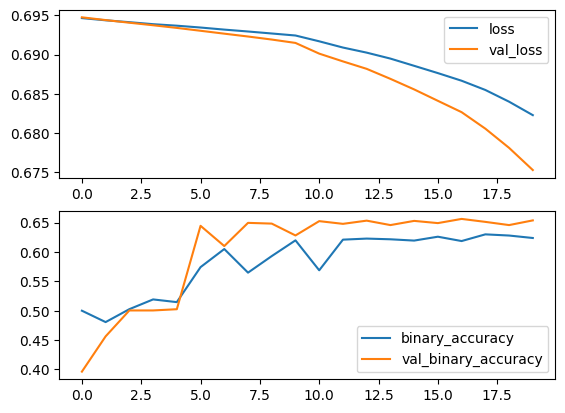

In [26]:
import matplotlib.pyplot as plt

def plot_model_results(history):
  fig, axs = plt.subplots(2)
  axs[0].plot(history['loss'], label='loss')
  axs[0].plot(history['val_loss'], label='val_loss')
  axs[0].legend()

  axs[1].plot(history['binary_accuracy'], label="binary_accuracy")
  axs[1].plot(history['val_binary_accuracy'], label="val_binary_accuracy")
  axs[1].legend()

plot_model_results(history.history)

## Conclusions

After lots of tweaking around with the variety of columns and training epochs/layers, we couldn't push above 67% accuracy purely using general team stats.

# Adding More Game Specific Stats

Goal: Determine if conditions per game affect outcome

- Days rest prior to game

- Number of injuries (?)

In [27]:
game_specific = prepare_dataset(season_2023, team_stats_2023)
game_specific

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,WIN
0,Portland Trail Blazers,POR,1610612757,0022301200,SAC,1610612758,L,0
1,Miami Heat,MIA,1610612748,0022301189,TOR,1610612761,W,1
2,Orlando Magic,ORL,1610612753,0022301191,MIL,1610612749,W,1
3,Dallas Mavericks,DAL,1610612742,0022301196,OKC,1610612760,L,0
4,Brooklyn Nets,BKN,1610612751,0022301192,PHI,1610612755,L,0
...,...,...,...,...,...,...,...,...
2455,LA Clippers,LAC,1610612746,0022300074,POR,1610612757,W,1
2456,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,1
2457,Los Angeles Lakers,LAL,1610612747,0022300061,DEN,1610612743,L,0
2458,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0


## Rest Days

We get rest days between games by assigning game IDs to their game date (The API did not originally give these pieces of data together)

If a team is playing their first game, we set rest games to 0.

In [28]:
from nba_api.stats.endpoints import leaguegamelog


log_2023 = leaguegamelog.LeagueGameLog(season=season_2023.formatted_season(), season_type_all_star="Regular Season")

log_2023 = log_2023.get_data_frames()[0]
log_2023

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22023,1610612747,LAL,Los Angeles Lakers,0022300061,2023-10-24,LAL @ DEN,L,240,41,...,31,44,23,5,4,12,18,107,-12,1
1,22023,1610612756,PHX,Phoenix Suns,0022300062,2023-10-24,PHX @ GSW,W,240,42,...,43,60,23,5,7,19,22,108,4,1
2,22023,1610612744,GSW,Golden State Warriors,0022300062,2023-10-24,GSW vs. PHX,L,240,36,...,31,49,19,11,6,11,23,104,-4,1
3,22023,1610612743,DEN,Denver Nuggets,0022300061,2023-10-24,DEN vs. LAL,W,240,48,...,33,42,29,9,6,12,15,119,12,1
4,22023,1610612754,IND,Indiana Pacers,0022300064,2023-10-25,IND vs. WAS,W,240,56,...,41,51,38,10,8,12,23,143,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,22023,1610612739,CLE,Cleveland Cavaliers,0022301187,2024-04-14,CLE vs. CHA,L,240,44,...,31,43,30,4,1,14,8,110,-10,1
2456,22023,1610612754,IND,Indiana Pacers,0022301188,2024-04-14,IND vs. ATL,W,240,65,...,36,48,41,10,6,16,24,157,42,1
2457,22023,1610612756,PHX,Phoenix Suns,0022301194,2024-04-14,PHX @ MIN,W,240,47,...,19,32,28,13,3,13,24,125,19,1
2458,22023,1610612740,NOP,New Orleans Pelicans,0022301195,2024-04-14,NOP vs. LAL,L,240,41,...,29,39,26,8,1,19,17,108,-16,1


In [29]:
cleaned = log_2023[["GAME_ID", "GAME_DATE"]]
cleaned = cleaned.drop_duplicates()
cleaned

,GAME_ID,GAME_DATE
0,0022300061,2023-10-24
1,0022300062,2023-10-24
4,0022300064,2023-10-25
5,0022300069,2023-10-25
6,0022300066,2023-10-25
...,...,...
2444,0022301192,2024-04-14
2447,0022301196,2024-04-14
2448,0022301198,2024-04-14
2449,0022301187,2024-04-14


In [30]:
with_dates = pd.merge(game_specific, cleaned, how="left", on="GAME_ID")
with_dates["LAST_GAME_DATE"] = with_dates.sort_values(by="GAME_DATE").groupby(["TEAM_ID"])["GAME_DATE"].shift(1)
with_dates["LAST_GAME_DATE"] = with_dates["LAST_GAME_DATE"].fillna(with_dates["GAME_DATE"])
with_dates["GAME_DATE"] = pd.to_datetime(with_dates["GAME_DATE"])
with_dates["LAST_GAME_DATE"] = pd.to_datetime(with_dates["LAST_GAME_DATE"])
with_dates["NUM_REST_DAYS"] = (with_dates["GAME_DATE"] - with_dates["LAST_GAME_DATE"]).dt.days
with_dates

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,WIN,GAME_DATE,LAST_GAME_DATE,NUM_REST_DAYS
0,Portland Trail Blazers,POR,1610612757,0022301200,SAC,1610612758,L,0,2024-04-14,2024-04-12,2
1,Miami Heat,MIA,1610612748,0022301189,TOR,1610612761,W,1,2024-04-14,2024-04-12,2
2,Orlando Magic,ORL,1610612753,0022301191,MIL,1610612749,W,1,2024-04-14,2024-04-12,2
3,Dallas Mavericks,DAL,1610612742,0022301196,OKC,1610612760,L,0,2024-04-14,2024-04-12,2
4,Brooklyn Nets,BKN,1610612751,0022301192,PHI,1610612755,L,0,2024-04-14,2024-04-12,2
...,...,...,...,...,...,...,...,...,...,...,...
2455,LA Clippers,LAC,1610612746,0022300074,POR,1610612757,W,1,2023-10-25,2023-10-25,0
2456,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,1,2023-10-24,2023-10-24,0
2457,Los Angeles Lakers,LAL,1610612747,0022300061,DEN,1610612743,L,0,2023-10-24,2023-10-24,0
2458,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0,2023-10-24,2023-10-24,0


## Generalized approach

We can now generalize this approach into a function for each season

In [31]:
# We assume the input is one of the basic DataFrame formats
# we created earlier in this notebook with each row
# corresponding to one team's view of a match
def add_days_rest_column(season: Season, basic_game_data: pd.DataFrame):
  log = leaguegamelog.LeagueGameLog(season=season.formatted_season(), season_type_all_star="Regular Season")
  log = log.get_data_frames()[0]

  deduplicated = log[["GAME_ID", "GAME_DATE"]]
  deduplicated = deduplicated.drop_duplicates()

  with_dates = pd.merge(basic_game_data, deduplicated, how="left", on="GAME_ID")
  with_dates["LAST_GAME_DATE"] = with_dates.sort_values(by="GAME_DATE").groupby(["TEAM_ID"])["GAME_DATE"].shift(1)
  with_dates["LAST_GAME_DATE"] = with_dates["LAST_GAME_DATE"].fillna(with_dates["GAME_DATE"])
  with_dates["GAME_DATE"] = pd.to_datetime(with_dates["GAME_DATE"])
  with_dates["LAST_GAME_DATE"] = pd.to_datetime(with_dates["LAST_GAME_DATE"])
  with_dates["NUM_REST_DAYS"] = (with_dates["GAME_DATE"] - with_dates["LAST_GAME_DATE"]).dt.days
  return with_dates

add_days_rest_column(season_2023, games_2023)

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN,GAME_DATE,LAST_GAME_DATE,NUM_REST_DAYS
0,Milwaukee Bucks,MIL,1610612749,0022301191,ORL,1610612753,L,0.598,0.573,0,2024-04-14,2024-04-12,2
1,Golden State Warriors,GSW,1610612744,0022301198,UTA,1610612762,W,0.561,0.378,1,2024-04-14,2024-04-12,2
2,Orlando Magic,ORL,1610612753,0022301191,MIL,1610612749,W,0.573,0.598,1,2024-04-14,2024-04-12,2
3,Cleveland Cavaliers,CLE,1610612739,0022301187,CHA,1610612766,L,0.585,0.256,0,2024-04-14,2024-04-12,2
4,Chicago Bulls,CHI,1610612741,0022301190,NYK,1610612752,L,0.476,0.610,0,2024-04-14,2024-04-12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,Washington Wizards,WAS,1610612764,0022300064,IND,1610612754,L,0.183,0.573,0,2023-10-25,2023-10-25,0
2456,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,0.598,0.561,1,2023-10-24,2023-10-24,0
2457,Denver Nuggets,DEN,1610612743,0022300061,LAL,1610612747,W,0.695,0.573,1,2023-10-24,2023-10-24,0
2458,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0.561,0.598,0,2023-10-24,2023-10-24,0


## Neural Network + Rest Days

We apply rest days to our neural network

In [32]:
rest_days_2021 = add_days_rest_column(season_2021, games_2021)
rest_days_2022 = add_days_rest_column(season_2022, games_2022)
rest_days_2023 = add_days_rest_column(season_2023, games_2023)

rest_days_merged = pd.concat([rest_days_2021, rest_days_2022, rest_days_2023])
rest_days_merged = rest_days_merged.sample(frac=1) # Shuffle the data
rest_days_merged

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN,GAME_DATE,LAST_GAME_DATE,NUM_REST_DAYS
1350,Atlanta Hawks,ATL,1610612737,0022300521,PHI,1610612755,W,0.439,0.573,1,2024-01-10,2024-01-07,3
416,Atlanta Hawks,ATL,1610612737,0022201021,MIN,1610612750,L,0.500,0.512,0,2023-03-13,2023-03-11,2
2065,New Orleans Pelicans,NOP,1610612740,0022300222,SAC,1610612758,W,0.598,0.561,1,2023-11-20,2023-11-18,2
860,Detroit Pistons,DET,1610612765,0022200794,PHX,1610612756,L,0.207,0.549,0,2023-02-04,2023-02-03,1
1734,Los Angeles Lakers,LAL,1610612747,0022100365,BOS,1610612738,W,0.402,0.622,1,2021-12-07,2021-12-03,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,Los Angeles Lakers,LAL,1610612747,0022201212,PHX,1610612756,W,0.524,0.549,1,2023-04-07,2023-04-05,2
2323,Utah Jazz,UTA,1610612762,0022100068,HOU,1610612745,W,0.598,0.244,1,2021-10-28,2021-10-26,2
96,Detroit Pistons,DET,1610612765,0022301145,PHI,1610612755,L,0.171,0.573,0,2024-04-09,2024-04-06,3
1707,Washington Wizards,WAS,1610612764,0022300347,PHX,1610612756,L,0.183,0.598,0,2023-12-17,2023-12-15,2


In [33]:
rest_days_stats = generate_nn_labels(["W_PCT"])
rest_days_stats.append("NUM_REST_DAYS")
raw_input_cols = rest_days_merged[rest_days_stats].to_numpy()
raw_input_cols

array([[0.439, 0.573, 3.   ],
       [0.5  , 0.512, 2.   ],
       [0.598, 0.561, 2.   ],
       ...,
       [0.171, 0.573, 3.   ],
       [0.183, 0.598, 2.   ],
       [0.61 , 0.598, 2.   ]])

In [34]:
raw_rest_days_outputs = rest_days_merged["WIN"].to_numpy()
raw_rest_days_outputs

array([1, 0, 1, ..., 0, 0, 0])

In [35]:
training_size = 5000

train_input = raw_input_cols[:training_size]
train_label = raw_rest_days_outputs[:training_size]

test_input = raw_input_cols[training_size:]
test_label = raw_rest_days_outputs[training_size:]

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.4814 - loss: 0.7149 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5290 - val_loss: 0.7071
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.4970 - loss: 0.7063 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5273 - val_loss: 0.7049
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5110 - loss: 0.7047 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5034 - val_loss: 0.7035
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5231 - loss: 0.7031 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5088 - val_loss: 0.7018
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5580 - loss: 0.7011 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6088 - val_loss: 0.7003
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━

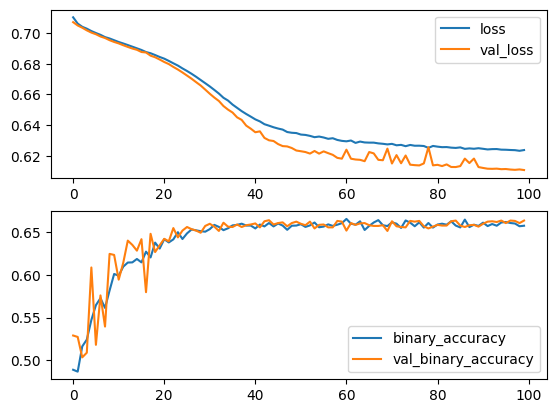

In [36]:
from keras.regularizers import l2

lmbda = 0.01

rest_days_model = Sequential()
rest_days_model.add(keras.Input(shape=(3,)))
rest_days_model.add(Dense(20, activation = 'relu'))
rest_days_model.add(Dense(10, activation = 'relu'))
rest_days_model.add(Dense(1, kernel_regularizer=l2(lmbda), activation='sigmoid'))

rest_days_model.compile(optimizer='sgd',
              loss=BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Accuracy()])

# fit the model to the training data
history = rest_days_model.fit(train_input, train_label, epochs=100, validation_data = (test_input, test_label))

result = rest_days_model.evaluate(x=test_input, y=test_label)
dict(zip(rest_days_model.metrics_names, result))

plot_model_results(history.history)

# Using RNN

RNN for Naive Win Percentage

In [37]:
sorted_seasons_by_date = rest_days_merged.sort_values(by="GAME_DATE").copy()
sorted_seasons_by_date

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN,GAME_DATE,LAST_GAME_DATE,NUM_REST_DAYS
2456,Los Angeles Lakers,LAL,1610612747,0022100002,GSW,1610612744,L,0.402,0.646,0,2021-10-19,2021-10-19,0
2457,Golden State Warriors,GSW,1610612744,0022100002,LAL,1610612747,W,0.646,0.402,1,2021-10-19,2021-10-19,0
2459,Milwaukee Bucks,MIL,1610612749,0022100001,BKN,1610612751,W,0.622,0.537,1,2021-10-19,2021-10-19,0
2458,Brooklyn Nets,BKN,1610612751,0022100001,MIL,1610612749,L,0.537,0.622,0,2021-10-19,2021-10-19,0
2455,Washington Wizards,WAS,1610612764,0022100006,TOR,1610612761,W,0.427,0.585,1,2021-10-20,2021-10-20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,Minnesota Timberwolves,MIN,1610612750,0022301194,PHX,1610612756,L,0.683,0.598,0,2024-04-14,2024-04-12,2
18,New York Knicks,NYK,1610612752,0022301190,CHI,1610612741,W,0.610,0.476,1,2024-04-14,2024-04-12,2
29,Denver Nuggets,DEN,1610612743,0022301193,MEM,1610612763,W,0.695,0.329,1,2024-04-14,2024-04-12,2
25,Portland Trail Blazers,POR,1610612757,0022301200,SAC,1610612758,L,0.256,0.561,0,2024-04-14,2024-04-12,2


In [38]:
rnn_naive_stats = generate_nn_labels(["W_PCT"])
rnn_naive_input = sorted_seasons_by_date[rnn_naive_stats].to_numpy()

rnn_naive_output = sorted_seasons_by_date["WIN"].to_numpy()

In [39]:
#arbitrary sequence length
sequence_length = 10

def create_naive_sequences(inputs, targets, sequence_length=sequence_length):
    X, y = [], []
    for i in range(len(inputs) - sequence_length + 1):
        X.append(inputs[i:i+sequence_length])
        y.append(targets[i+sequence_length - 1])  #predict result of last game
    return np.array(X), np.array(y)

X, y = create_naive_sequences(rnn_naive_input, rnn_naive_output)

RNN_naive_model = Sequential([
    LSTM(32, input_shape=(sequence_length, X.shape[2])),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
split_index = int(0.8 * len(X))
train_input = X[:split_index]
train_label = y[:split_index]
test_input = X[split_index:]
test_label = y[split_index:]

RNN_naive_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = RNN_naive_model.fit(train_input, train_label, epochs=100, validation_data = (test_input, test_label))

result = RNN_naive_model.evaluate(x=test_input, y=test_label)
print(dict(zip(RNN_naive_model.metrics_names, result)))

Epoch 1/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5059 - loss: 0.6926 - val_accuracy: 0.5037 - val_loss: 0.6862
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5758 - loss: 0.6827 - val_accuracy: 0.6671 - val_loss: 0.6371
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6521 - loss: 0.6430 - val_accuracy: 0.6556 - val_loss: 0.6029
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6380 - loss: 0.6311 - val_accuracy: 0.6631 - val_loss: 0.5954
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6572 - loss: 0.6175 - val_accuracy: 0.6651 - val_loss: 0.5997
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6517 - loss: 0.6179 - val_accuracy: 0.6603 - val_loss: 0.5960
Epoch 7/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6626 - loss: 0.6161 - val_accuracy: 0.6542 - val_loss: 0.5959
Epoch 8/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6506 - loss: 0.6213 - val_acc

Testing with Individual Seasons

In [41]:
season_21_sorted = rest_days_2021.sort_values(by="GAME_DATE").copy()

rnn_naive_stats_21 = generate_nn_labels(["W_PCT"])
rnn_naive_input_21 = sorted_seasons_by_date[rnn_naive_stats].to_numpy()

rnn_naive_output_21 = sorted_seasons_by_date["WIN"].to_numpy()

X, y = create_naive_sequences(rnn_naive_input_21, rnn_naive_output_21)

RNN_naive_model_21 = Sequential([
    LSTM(32, input_shape=(sequence_length, X.shape[2])),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
split_index = int(0.8 * len(X))
train_input = X[:split_index]
train_label = y[:split_index]
test_input = X[split_index:]
test_label = y[split_index:]

RNN_naive_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = RNN_naive_model.fit(train_input, train_label, epochs=100, validation_data = (test_input, test_label))

result = RNN_naive_model.evaluate(x=test_input, y=test_label)
print(dict(zip(RNN_naive_model.metrics_names, result)))

Epoch 1/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6721 - loss: 0.5990 - val_accuracy: 0.6576 - val_loss: 0.6049
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6632 - loss: 0.6098 - val_accuracy: 0.6651 - val_loss: 0.6106
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6673 - loss: 0.6087 - val_accuracy: 0.6603 - val_loss: 0.6074
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6602 - loss: 0.6073 - val_accuracy: 0.6549 - val_loss: 0.6189
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6664 - loss: 0.6050 - val_accuracy: 0.6515 - val_loss: 0.6091
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6588 - loss: 0.6084 - val_accuracy: 0.6563 - val_loss: 0.6074
Epoch 7/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6445 - loss: 0.6116 - val_accuracy: 0.6549 - val_loss: 0.6093
Epoch 8/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6679 - loss: 0.6059 - val_acc

# Testing RNN Model with Rolling Team Win Percentage

Previous data sets only had static win percentages, so we wanted to test if adding rolling win percentage would help. Rolling win percentage adds another temporal aspect to the data tables. Possibly give the RNN more info to work off albeit it is much more variable.

In [43]:
#using already existing for dates
rolling_win = pd.concat([rest_days_2021, rest_days_2022, rest_days_2023])

#sorting games by date to make chronological
#Only dealing with on team for now can add entire data set later
rolling_win = rolling_win.sort_values(by="GAME_DATE")
display(rolling_win[rolling_win['TEAM_ABBREVIATION'] == 'BOS'])


,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN,GAME_DATE,LAST_GAME_DATE,NUM_REST_DAYS
2452,Boston Celtics,BOS,1610612738,0022100005,NYK,1610612752,L,0.622,0.451,0,2021-10-20,2021-10-20,0
2416,Boston Celtics,BOS,1610612738,0022100020,TOR,1610612761,L,0.622,0.585,0,2021-10-22,2021-10-20,2
2382,Boston Celtics,BOS,1610612738,0022100037,HOU,1610612745,W,0.622,0.244,1,2021-10-24,2021-10-22,2
2374,Boston Celtics,BOS,1610612738,0022100041,CHA,1610612766,W,0.622,0.524,1,2021-10-25,2021-10-24,1
2340,Boston Celtics,BOS,1610612738,0022100056,WAS,1610612764,L,0.622,0.427,0,2021-10-27,2021-10-25,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Boston Celtics,BOS,1610612738,0022301134,POR,1610612757,W,0.780,0.256,1,2024-04-07,2024-04-05,2
92,Boston Celtics,BOS,1610612738,0022301148,MIL,1610612749,L,0.780,0.598,0,2024-04-09,2024-04-07,2
63,Boston Celtics,BOS,1610612738,0022301167,NYK,1610612752,L,0.780,0.610,0,2024-04-11,2024-04-09,2
51,Boston Celtics,BOS,1610612738,0022301173,CHA,1610612766,W,0.780,0.256,1,2024-04-12,2024-04-11,1


In [44]:
# Helper function to create a rolling win percentage of a team up until the given date/game
# Previously all our win percentages were end of season stats and didn't change on game by game basis.
# Set up to work for multiple teams in one dataset
def add_rolling_win_pct(df: pd.DataFrame) -> pd.DataFrame:
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    # Sort by TEAM_ID and GAME_DATE to maintain chronological order per team
    df = df.sort_values(by=['TEAM_ID', 'GAME_DATE']).copy()

    # Group by team and calculate cumulative wins and games played (excluding current row)
    df['ROLLING_WINS'] = df.groupby('TEAM_ID')['WIN'].cumsum().shift(1, fill_value=0)
    df['ROLLING_GAMES'] = df.groupby('TEAM_ID').cumcount()

    df['ROLLING_WIN_PCT'] = df['ROLLING_WINS'] / df['ROLLING_GAMES']

    return df

celtics_season_21 = rest_days_2021[rest_days_2021['TEAM_ABBREVIATION'] == 'BOS'].sort_values(by=['GAME_DATE']).copy()
celtics_season_21 = add_rolling_win_pct(celtics_season_21)
celtics_season_22 = rest_days_2022[rest_days_2022['TEAM_ABBREVIATION'] == 'BOS'].sort_values(by=['GAME_DATE']).copy()
celtics_season_22 = add_rolling_win_pct(celtics_season_22)
celtics_season_23 = rest_days_2023[rest_days_2023['TEAM_ABBREVIATION'] == 'BOS'].sort_values(by=['GAME_DATE']).copy()
celtics_season_23 = add_rolling_win_pct(celtics_season_23)

combined_celtics = pd.concat([celtics_season_21, celtics_season_22, celtics_season_23])
display(combined_celtics)


,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN,GAME_DATE,LAST_GAME_DATE,NUM_REST_DAYS,ROLLING_WINS,ROLLING_GAMES,ROLLING_WIN_PCT
2452,Boston Celtics,BOS,1610612738,0022100005,NYK,1610612752,L,0.622,0.451,0,2021-10-20,2021-10-20,0,0,0,NaN
2416,Boston Celtics,BOS,1610612738,0022100020,TOR,1610612761,L,0.622,0.585,0,2021-10-22,2021-10-20,2,0,1,0.000000
2382,Boston Celtics,BOS,1610612738,0022100037,HOU,1610612745,W,0.622,0.244,1,2021-10-24,2021-10-22,2,0,2,0.000000
2374,Boston Celtics,BOS,1610612738,0022100041,CHA,1610612766,W,0.622,0.524,1,2021-10-25,2021-10-24,1,1,3,0.333333
2340,Boston Celtics,BOS,1610612738,0022100056,WAS,1610612764,L,0.622,0.427,0,2021-10-27,2021-10-25,2,2,4,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Boston Celtics,BOS,1610612738,0022301134,POR,1610612757,W,0.780,0.256,1,2024-04-07,2024-04-05,2,61,77,0.792208
92,Boston Celtics,BOS,1610612738,0022301148,MIL,1610612749,L,0.780,0.598,0,2024-04-09,2024-04-07,2,62,78,0.794872
63,Boston Celtics,BOS,1610612738,0022301167,NYK,1610612752,L,0.780,0.610,0,2024-04-11,2024-04-09,2,62,79,0.784810
51,Boston Celtics,BOS,1610612738,0022301173,CHA,1610612766,W,0.780,0.256,1,2024-04-12,2024-04-11,1,62,80,0.775000


In [45]:
rnn_stats = generate_nn_labels(["W_PCT"])
rnn_stats.append('ROLLING_WIN_PCT')
rnn_stats.append('NUM_REST_DAYS')
raw_input_cols = combined_celtics[rnn_stats].to_numpy()
raw_input_cols

array([[0.622     , 0.451     ,        nan, 0.        ],
       [0.622     , 0.585     , 0.        , 2.        ],
       [0.622     , 0.244     , 0.        , 2.        ],
       [0.622     , 0.524     , 0.33333333, 1.        ],
       [0.622     , 0.427     , 0.5       , 2.        ],
       [0.622     , 0.427     , 0.4       , 3.        ],
       [0.622     , 0.561     , 0.33333333, 2.        ],
       [0.622     , 0.268     , 0.28571429, 2.        ],
       [0.622     , 0.646     , 0.375     , 1.        ],
       [0.622     , 0.634     , 0.44444444, 2.        ],
       [0.622     , 0.585     , 0.4       , 4.        ],
       [0.622     , 0.622     , 0.45454545, 2.        ],
       [0.622     , 0.537     , 0.5       , 1.        ],
       [0.622     , 0.537     , 0.46153846, 2.        ],
       [0.622     , 0.524     , 0.5       , 2.        ],
       [0.622     , 0.402     , 0.46666667, 2.        ],
       [0.622     , 0.293     , 0.5       , 1.        ],
       [0.622     , 0.244     ,

In [46]:
raw_output_celtics = combined_celtics["WIN"].to_numpy()
raw_output_celtics

array([0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1])

In [70]:
from tensorflow.keras.layers import Masking

#this is arbitrary length
sequence_length = 10

# Helper function to make valid sequences
# Sequences must stay within their valid seasons. This means NaN can only appear as first value in a sequence. Otherwise indicates change of season
def create_sequences(inputs, targets):
    sequences = []
    labels = []
    for i in range(len(inputs) - sequence_length + 1):
        x_seq = inputs[i:i + sequence_length]
        y = targets[i + sequence_length - 1]

        # Check for NaN
        if np.isnan(x_seq).any():
            continue

        sequences.append(x_seq)
        labels.append(y)

    return np.array(sequences), np.array(labels)

X, y = create_sequences(raw_input_cols, raw_output_celtics)
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

RNN_model = Sequential([
    Masking(mask_value=np.nan, input_shape=(sequence_length, X.shape[2])), #gets model to ignore any NaN in sequence
    LSTM(128, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
RNN_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Shape of X: (216, 10, 4)
Shape of y: (216,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [71]:
#Making training data
split_index = int(0.8 * len(X))
train_input = X[:split_index]
train_label = y[:split_index]
test_input = X[split_index:]
test_label = y[split_index:]

history = RNN_model.fit(train_input, train_label, epochs=100, validation_data = (test_input, test_label))

result = RNN_model.evaluate(x=test_input, y=test_label)
dict(zip(rest_days_model.metrics_names, result))

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5304 - loss: 0.6938 - val_accuracy: 0.7955 - val_loss: 0.5810
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6797 - loss: 0.6332 - val_accuracy: 0.7955 - val_loss: 0.5113
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6960 - loss: 0.6221 - val_accuracy: 0.7955 - val_loss: 0.5475
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6438 - loss: 0.6649 - val_accuracy: 0.7955 - val_loss: 0.5718
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6756 - loss: 0.6323 - val_accuracy: 0.7955 - val_loss: 0.5198
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7049 - loss: 0.6088 - val_accuracy: 0.7955 - val_loss: 0.5255
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6785 - loss: 0.6301 - val_accuracy: 0.7955 - val_loss: 0.5646
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6662 - loss: 0.6382 - val_accuracy: 0.7955 - val_loss

{'loss': 0.6903397440910339, 'compile_metrics': 0.75}

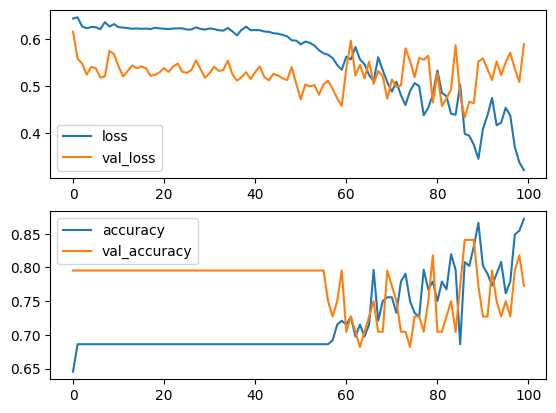

In [65]:
fig, axs = plt.subplots(2)
axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label="accuracy")
axs[1].plot(history.history['val_accuracy'], label="val_accuracy")
axs[1].legend()

In [50]:
preds = RNN_model.predict(test_input)
np.round(np.mean(preds), 2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


np.float32(0.71)

Okay ngl, I this model is kinda just dog. Feels like the model isn't actually learning anything but rather predicting off w_pct


#More data: More teams/ more features

In [51]:
log_2023 = leaguegamelog.LeagueGameLog(season=season_2023.formatted_season(), season_type_all_star="Regular Season")
log_2022 = leaguegamelog.LeagueGameLog(season=season_2022.formatted_season(), season_type_all_star="Regular Season")
log_2021 = leaguegamelog.LeagueGameLog(season=season_2021.formatted_season(), season_type_all_star="Regular Season")

combined_more_stats = pd.concat([log_2021.get_data_frames()[0], log_2022.get_data_frames()[0], log_2023.get_data_frames()[0]])
combined_more_stats = combined_more_stats.drop_duplicates()

sorted_seasons_by_date

desired_columns = ["GAME_ID", "TEAM_ID", "FGA", "FG_PCT", "FG3_PCT", "FT_PCT", "OREB", "DREB", "AST", "TOV", "STL", "PLUS_MINUS"]

combined_more_stats_filter = combined_more_stats[desired_columns]

giga_combined_data_set_with_more_things = pd.merge(sorted_seasons_by_date, combined_more_stats_filter, on=["GAME_ID", "TEAM_ID"], how="left")
giga_combined_data_set_with_more_things = add_rolling_win_pct(giga_combined_data_set_with_more_things)

giga_combined_data_set_with_more_things

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN,...,FT_PCT,OREB,DREB,AST,TOV,STL,PLUS_MINUS,ROLLING_WINS,ROLLING_GAMES,ROLLING_WIN_PCT
27,Atlanta Hawks,ATL,1610612737,0022100014,DAL,1610612742,W,0.524,0.634,1,...,0.889,6,49,31,13,8,26,0,0,NaN
52,Atlanta Hawks,ATL,1610612737,0022100027,CLE,1610612739,L,0.524,0.537,0,...,0.600,17,37,20,9,5,-6,1,1,1.000000
80,Atlanta Hawks,ATL,1610612737,0022100043,DET,1610612765,W,0.524,0.280,1,...,0.857,10,39,24,16,11,18,1,2,0.500000
108,Atlanta Hawks,ATL,1610612737,0022100059,NOP,1610612740,W,0.524,0.439,1,...,0.824,21,34,21,11,4,3,2,3,0.666667
129,Atlanta Hawks,ATL,1610612737,0022100066,WAS,1610612764,L,0.524,0.427,0,...,0.643,6,37,26,13,4,-11,3,4,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7248,Charlotte Hornets,CHA,1610612766,0022301135,OKC,1610612760,L,0.256,0.695,0,...,0.786,7,29,29,18,12,-3,89,241,0.369295
7279,Charlotte Hornets,CHA,1610612766,0022301144,DAL,1610612742,L,0.256,0.610,0,...,0.762,8,31,24,12,8,-26,89,242,0.367769
7309,Charlotte Hornets,CHA,1610612766,0022301159,ATL,1610612737,W,0.256,0.439,1,...,0.955,5,28,25,14,11,1,89,243,0.366255
7330,Charlotte Hornets,CHA,1610612766,0022301173,BOS,1610612738,L,0.256,0.780,0,...,0.864,4,29,20,20,3,-33,90,244,0.368852


In [52]:
giga_rnn_stats = generate_nn_labels(["W_PCT"])
giga_rnn_stats.extend(['ROLLING_WIN_PCT', 'NUM_REST_DAYS'])
giga_rnn_stats.extend(desired_columns[1:])
raw_giga_input_cols = giga_combined_data_set_with_more_things[giga_rnn_stats].to_numpy()
raw_giga_input_cols

array([[  0.524     ,   0.634     ,          nan, ...,  13.        ,
          8.        ,  26.        ],
       [  0.524     ,   0.537     ,   1.        , ...,   9.        ,
          5.        ,  -6.        ],
       [  0.524     ,   0.28      ,   0.5       , ...,  16.        ,
         11.        ,  18.        ],
       ...,
       [  0.256     ,   0.439     ,   0.36625514, ...,  14.        ,
         11.        ,   1.        ],
       [  0.256     ,   0.78      ,   0.36885246, ...,  20.        ,
          3.        , -33.        ],
       [  0.256     ,   0.585     ,   0.36734694, ...,  10.        ,
         10.        ,  10.        ]])

In [53]:
raw_output_giga = giga_combined_data_set_with_more_things["WIN"].to_numpy()
raw_output_giga

array([1, 0, 1, ..., 1, 0, 1])

In [59]:
X, y = create_naive_sequences(rnn_naive_input, rnn_naive_output)

sequence_length = 10
RNN_giga_model = Sequential([
    LSTM(32, input_shape=(sequence_length, X.shape[2])),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
split_index = int(0.8 * len(X))
train_input = X[:split_index]
train_label = y[:split_index]
test_input = X[split_index:]
test_label = y[split_index:]

RNN_giga_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = RNN_giga_model.fit(train_input, train_label, epochs=100, validation_data = (test_input, test_label))

result = RNN_naive_model.evaluate(x=test_input, y=test_label)
print(dict(zip(RNN_naive_model.metrics_names, result)))

Epoch 1/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5189 - loss: 0.6923 - val_accuracy: 0.5566 - val_loss: 0.6831
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6063 - loss: 0.6776 - val_accuracy: 0.6454 - val_loss: 0.6302
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6343 - loss: 0.6436 - val_accuracy: 0.6569 - val_loss: 0.6013
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6602 - loss: 0.6190 - val_accuracy: 0.6556 - val_loss: 0.5957
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6487 - loss: 0.6221 - val_accuracy: 0.6542 - val_loss: 0.5964
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6578 - loss: 0.6152 - val_accuracy: 0.6583 - val_loss: 0.5952
Epoch 7/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6623 - loss: 0.6160 - val_accuracy: 0.6610 - val_loss: 0.5990
Epoch 8/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6565 - loss: 0.6122 - val_acc

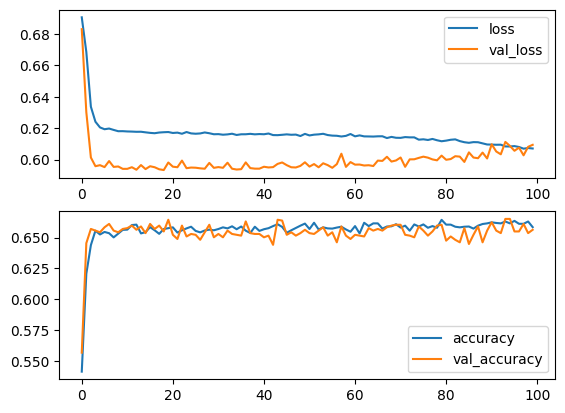

In [61]:
fig, axs = plt.subplots(2)
axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label="accuracy")
axs[1].plot(history.history['val_accuracy'], label="val_accuracy")
axs[1].legend()

# Predicting Sets of 10 Games
Because the RNN requires segments of 10, we set up 20 game chunks, treating the first 10 games as initial input and guessing the next 10 games.

We chose to use the RNN with just the Celtics data since it had the highest accuracy

Evaluating chunk starting at: 2021-10-20 00:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.0895
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.2077
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0000e+00 - loss: 1.4005
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.0000e+00 - loss: 4.6395
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.0000e+00 - loss: 4.3662
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0000e+00 - loss: 0.8593
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0503
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.1055
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0000e+00 - loss: 6.4931
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0000e+00 - loss: 1.0542
Evaluating chunk starting at: 2021-11-28 00:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.0000e+00 - loss: 2.2116
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0000e+00 - loss: 8.4110
1/1 

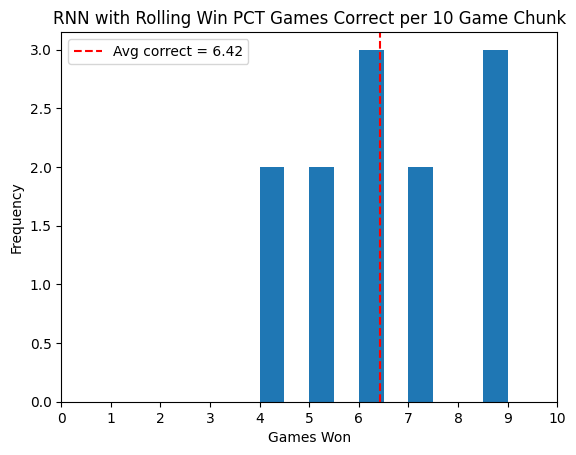

In [72]:
CELTICS_ID = 1610612738
c_games = giga_combined_data_set_with_more_things[giga_combined_data_set_with_more_things["TEAM_ID"] == CELTICS_ID].sort_values("GAME_DATE").reset_index()

chunk_size = 20 # Split into 10 consecutive games
chunk_list = [c_games[i:i + chunk_size] for i in range(0, c_games.shape[0], chunk_size)]
chunk_list[0]

# Return number of games won in the chunk
def evaluate_rnn_chunk(model, stats, games, debug=False) -> int:
  games = games.reset_index(drop=True)
  print("Evaluating chunk starting at: " + str(games.at[0, "GAME_DATE"]))
  games_won = 0
  for i in range(0, 10):
    game_input = games.iloc[i:i+10][stats].to_numpy(dtype="float32")
    game_input = np.array([game_input])
    game_result = np.array([games.at[i+10, "WIN"]])
    result = model.evaluate(x=game_input, y=game_result)
    if debug:
      print("Actual Result: {}, Predicted: {}".format(games['WIN'], result[1]))
    # We correctly predicted the result
    if result[1]:
      games_won += 1
  return games_won


games_correctly_guessed = []
for chunk in chunk_list:
  if len(chunk.index) != chunk_size:
    # Not fair to count a chunk less than 10 games
    continue
  won = evaluate_rnn_chunk(model=RNN_model, stats=rnn_stats, games=chunk)
  games_correctly_guessed.append(won)

def plot_correct_games(title, correct_games):
  plt.hist(correct_games, density=False)
  plt.title(title)
  plt.ylabel('Frequency')
  plt.xlabel('Games Won');
  plt.xticks(np.arange(0, 11, step=1))

  avg_correct = sum(correct_games) / len(correct_games)
  avg_acc_chunk = avg_correct / chunk_size
  plt.axvline(avg_correct, color='red', linestyle='--', label=f"Avg correct = {avg_correct:.2f}")

  plt.legend()
  plt.show()

plot_correct_games(title="RNN with Rolling Win PCT Games Correct per 10 Game Chunk", correct_games=games_correctly_guessed)